The purpose of this notebook is to go through the basics of bayesian inference, in relation to fitting models. I am assuming you want to know how to fit models to data in a "bayesian" way.

Assumed knowledge: \
Bayes rule: $P(A|B) = P(B|A) P(A) / P(B)$ \
Independent product rule: $P(A\cap B) = P(A) P(B)$ if $A$ and $B$ are independent\
Familiar with Python.

First, lets make some data to fit. In this example, we are going with linear data with some noise added to it. Gradient 0.51, intercept 6.2, gaussian noise with standard deviation 0.5. 

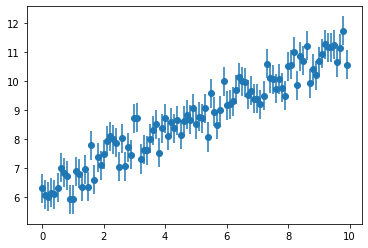

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# setting seed for reproducability
np.random.seed(19) 
def f(x): return 0.51*x+6.2 + 0.5*np.random.randn(len(x))

xdata = np.arange(0, 10, 0.1)
ydata = f(xdata)
yerr = np.ones(len(xdata))*0.5
plt.errorbar(xdata, ydata, yerr=yerr, marker='o', linestyle='')
plt.show()

Fitting data requires a model. We can define what model we want to use, in this case, since the data looks linear, we will use a linear model. 

In [12]:
# x is the x data points, a is the gradient, b is the intercept
def model(x, a, b): return a*x+b

Now, we have the data we want to fit (with errors), and we have the model we want to fit the data with. A more common fitting proceedure will try to find the best $a$ and $b$ to fit the data (e.g. $\chi^2$ fitting). But bayesian inference not only asks what is the best $a$ and $b$, it also wants to know what the probability associated with a particular $a$ and $b$ is. 

We want to find the probability that the model is correct given the data, often referred to as the posterior, i.e. we want $P(M|D)$. \
Using bayes rule: $P(M|D) = P(M)P(D|M)/P(D)$ \
$P(D)$ is the probability that this dataset occurs. It is a scaling factor, usually you only have one dataset anyway, so this term can be ignored. \
$P(M)$ is the probaility that this model occurs, often referred to as the prior. This comes from domain knowledge, e.g. if my model has a value which can't be negative, we set the probability that this value is negative to 0, thus only allowing positive values. \
$P(D|M)$ is the probability that this dataset occurs given that this model is the real model, often referred to as the likelihood, we will spend time calculating this value. 

First, lets calculate $P(D|M)$. We will explore how $P(M)$ changes the results later. 

$P(D|M)$ is the probability that the dataset is real given this model, so we are in essence asking, what is the probability that all of these data points are real given the model, which means $P(D|M)$ can be written as $P(D_0 \cap D_1 ... \cap  D_n)|M)$, where $D_i$ is the ith data point and there are a total of $n$ data points.

An assumption you can usually make is that each data point was observed independently. Thus, $P(D|M)$ can be further written as \
$$P(D|M) = P(D_0|M) P(D_1|M) ... P(D_n|M) = \prod_{i=0}^{n} P(D_i|M) $$

Now, we can focus on calculating $P(D_0|M)$ then generalise this to other data points. 

To calculate $P(D_0|M)$, we have $x_0$, $y_0$, $\sigma_{y_0}$, and $m(x_0)$ the model evaluated at $x_0$ with some value for $a$ and $b$. We need to make another assumption here of what form of error we have. Usually it's safe to assume gaussian error (because central limit theorem), then $P(D_0|M)$ is given by 
$$P(D_0|M) = 1/(\sigma_{y_0}\sqrt{2\pi}) exp(-((y_0 - m(x_0))/\sigma_{y_0})^2)$$
In this, we are assuming that $m(x_0)$ is the mean of the gaussian distribution, $\sigma_{y_0}$ is the standard deviation, and $y_0$ is the random variable sampled from the gaussian distribution. Thus $P(D_0|M)$ should be the probability that this $y_0$ was sampled from a gaussian with mean $m(x_0)$ and standard deviation $\sigma_{y_0}$. You can see that $P(D_0|M)$ is smaller if $y_0$ and $m(x_0)$ have a larger difference, and this makes sense because $P(D_0|M)$ is how good the model is fitting, and it is lower if $y_0$ and $m(x_0)$ are more different. 

Normalising every step of the way is very annoying, so we will simply normalise at the end by throwing out the constant $1/\sqrt{2\pi}$, meaning we will calculate $P(D_0|M) \propto 1/\sigma_{y_0} exp(-((y_0 - m(x_0))/\sigma_{y_0})^2)$. You can go further by throwing out the $1/\sigma_{y_0}$ too, but only when $\sigma_{y_i}$ is constant, which isn't usually the case. 

A note here that if you do not have gaussian error, you can replace the probability formula with whatever form you believe your errors to be. 

In [13]:
# I just picked some value for a and b here. We will actually figure out the correct values later
a = 0.5
b = 6.2

x_obs = xdata[0]
y_obs = ydata[0]
y_err = yerr[0]
y_pred = model(x_obs, a, b)
prob = 1/y_err*np.exp(-((y_obs - y_pred)/y_err)**2)
print(prob)

1.9046623303233237


We just calculated $P(D_0|M)$, and we can generalise this formula to $P(D_i|M)$, remembering that $P(D|M)$ is $P(D_i|M)$ multiplied together, we can calculate $P(D|M)$

In [14]:
prob = 1 # basis for mulitiplication is 1 
for x_obs, y_obs, y_err in zip(xdata, ydata, yerr):
    prob *= 1/y_err*np.exp(-((y_obs - model(x_obs, a, b))/y_err)**2)
print(prob)

0.008518410679100957


Since we are multiplying small probabilities together without normalising, this does make the probability become very small very fast. This is one of the reasons why when dealing with probabilities we usually work in log space. 

Lets review the formula: 
$$P(D|M) = \prod_{i=0}^{n} P(D_i|M)$$
If I take the log of both sides:
$$\ln P(D|M) = \sum_{i=0}^{n} \ln P(D_i|M)$$
Convinently for gaussian error, there is an exponential in the equation, which basically cancels out with the log, so written out fully:
$$\ln P(D|M) = \sum_{i=0}^{n} ( -\ln \sigma_{y_i}-((y_i - m(x_i))/\sigma_{y_i})^2 ) $$

The other reason why we work in log space is because it's computationally faster. 

In [15]:
lnprob = 0 # basis for addition is 0 
for x_obs, y_obs, y_err in zip(xdata, ydata, yerr):
    lnprob += -np.log(y_err)-((y_obs - model(x_obs, a, b))/y_err)**2
print(lnprob)
print('If I take the exponential, I get back the original number:', np.exp(lnprob))

-4.765525495553289
If I take the exponential, I get back the original number: 0.008518410679100958


We're about to compute this formula many times, so just to make it faster computationally, we can throw it into numpy

In [16]:
def calc_lnprob(xdata, ydata, yerr, a, b):
    return np.sum(-np.log(y_err)-((ydata - model(xdata, a, b))/yerr)**2)

lnprob = calc_lnprob(xdata, ydata, yerr, a, b)
print('convince yourself this formula returns the same value:', lnprob)

convince yourself this formula returns the same value: -4.765525495553293


We have now completed the hard part, which is finding a formula for $P(D|M)$. You will have noticed I used a fix $a$ and $b$ to demonstrate the formula. But in reality, we are trying to fit for $a$ and $b$. Thus the next step in the process is to calculate $P(D|M)$ for mulitple models, or multiple $a$ and $b$ values to find the probabilities associated with these values and the best fit. 

best a: 0.504 best b: 6.239999999999995


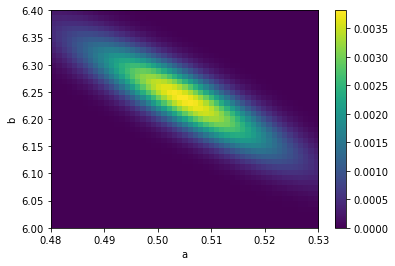

In [17]:
# make a, b values to sample through
aleft = 0.48
aright = 0.53
arange = np.arange(aleft, aright, 0.001)
bleft = 6.0
bright = 6.4
brange = np.arange(bleft, bright, 0.01)

# compute probabilities for a, b values
lnprobs = []
for b in brange:
    lnprobs.append([calc_lnprob(xdata, ydata, yerr, i, b) for i in arange])
lnprobs = np.array(lnprobs)

# find best fit (MAP in this case - note that you can use expectation value or whatever you please)
inds = np.where(lnprobs == np.max(lnprobs))
bmax = brange[inds[0][0]]
amax = arange[inds[1][0]]
print('best a:', amax, 'best b:', bmax)

# normalise 
lnprobs = lnprobs - np.max(lnprobs) # scale to 0 first to make numbers better to work with
probs = np.exp(lnprobs)
probs /= np.sum(probs) # doesn't take into account width, not a true normalisation, but it will do for visualisation

plt.imshow(probs, origin='lower', aspect='auto', extent=[aleft, aright, bleft, bright])
plt.xlabel('a')
plt.ylabel('b')
plt.colorbar()
plt.show()

These results show that $a$ and $b$ are correlated, i.e. to fit the data well, if $a$ increases, $b$ decreases - which makes sense. To fit a linear line, if the gradient increases, then the intercept must decrease to compensate. 

The best fits are also quite close to the original values of $a=0.51$ and $b=6.2$.

To show the most probable $P(D|M)$ and 2 less probable ones:

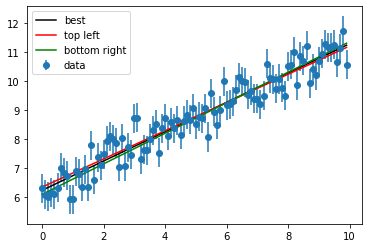

In [18]:
inds = np.where(probs == np.max(probs))
bmax = brange[inds[0][0]]
amax = arange[inds[1][0]]

plt.errorbar(xdata, ydata, yerr=yerr, marker='o', linestyle='', label='data')
plt.plot(xdata, xdata*amax+bmax, color='black', label='best')
plt.plot(xdata, xdata*0.485+6.35, color='red', label='top left')
plt.plot(xdata, xdata*0.525+6.1, color='green', label='bottom right')
plt.legend()
plt.show()

We're almost done, remember $P(M|D) = P(D|M) P(M)$. We just calculated $P(D|M)$, and if we have no prior (or uniform prior), then $P(M|D) = P(D|M)$ and we are done. However, if you do have a prior, for example, if I from some other method, believed that $b$ is gaussian centered at 5.9 with standard deviation 0.1, then my results would become:

best a: 0.53 best b: 6.069999999999997


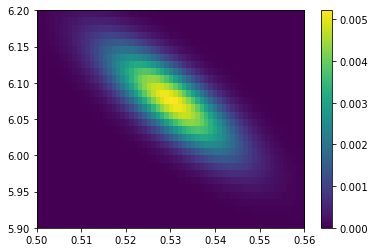

In [19]:
def calc_prior(b):
    return np.exp(-((b - 5.9)/0.1)**2)

aleft = 0.5
aright = 0.56
arange = np.arange(aleft, aright, 0.001)
bleft = 5.9
bright = 6.2
brange = np.arange(bleft, bright, 0.01)

lnprobs = []
for b in brange:
    lnprobs.append([calc_lnprob(xdata, ydata, yerr, i, b)+np.log(calc_prior(b)) for i in arange])
lnprobs = np.array(lnprobs)

# find best fit (MAP in this case - note that you can use expectation value or whatever you please)
inds = np.where(lnprobs == np.max(lnprobs))
bmax = brange[inds[0][0]]
amax = arange[inds[1][0]]
print('best a:', amax, 'best b:', bmax)

# normalise 
lnprobs = lnprobs - np.max(lnprobs) # scale to 0 first to make numbers better to work with
probs = np.exp(lnprobs)
probs /= np.sum(probs) # doesn't take into account width, not a true normalisation, but it will do for visualisation

plt.imshow(probs, origin='lower', aspect='auto', extent=[aleft, aright, bleft, bright])
plt.colorbar()
plt.show()

As you can see, the lower $b$ value (intercept) forced $a$ (gradient) to increase to compensate for the data. 

Compare to the inputted $a=0.51$ and $b=6.2$, I forced $b$ to be lower with the prior, so the measured $a$ is higher than the inputted $a$. \
Compare this to the previous best fit values of $a=0.504$ and $b=6.24$. Again, $a$ increased to compensate for $b$ being forced lower. 

Again, plotting the fits against the data to check:

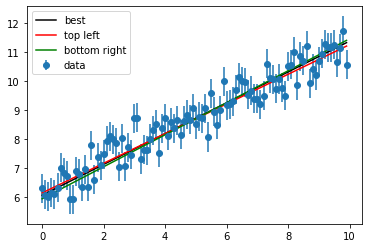

In [20]:
plt.errorbar(xdata, ydata, yerr=yerr, marker='o', linestyle='', label='data')
plt.plot(xdata, xdata*amax+bmax, color='black', label='best')
plt.plot(xdata, xdata*0.51+6.15, color='red', label='top left')
plt.plot(xdata, xdata*0.55+5.95, color='green', label='bottom right')
plt.legend()
plt.show()

Some extension...

If you have error in x as well as error in y, you'll need to use the error formula that incorporates errors in both x and y. For gaussian error, assuming non-independent error in x and y (x error and y error are correlated within a single data point, not the indvidual data points themselves!), see multivariate gaussian distribution.